<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skip connection in  [Resnet](https://arxiv.org/abs/1512.03385)

In ResNet architectures, a skip connection, often referred to as a "skip layer," provides a shortcut path for the input tensor to bypass one or more layers in the network.  Instead of directly feeding the output of a layer to the next, the skip connection adds the input tensor to the output of the layer.  Mathematically, this looks like:

`Output = F(Input) + Input`

where `F` represents the transformations performed by one or more layers within the residual block, and `Input` is the activation from the previous layer.

### Benefits of skip connection:

* **Addressing Vanishing/Exploding Gradients:**  The skip connection facilitates the flow of gradients during backpropagation, helping to mitigate the vanishing or exploding gradient problem. The direct path for the gradients allows them to propagate more easily through the network, especially in deep architectures where these problems are more pronounced.  The gradients have an easier path to update weights in earlier layers, allowing the network to learn effectively.

* **Enabling Deeper Networks:**  By easing gradient flow, skip connections enable the training of significantly deeper networks.  Deeper networks, in theory, have greater capacity to learn complex features. Without skip connections, very deep networks are difficult or impossible to train due to vanishing gradients.

* **Improved Optimization:** Skip connections are not simply a shortcut for the data, but a mechanism to optimize the network. The network learns *residual functions* — the difference between the desired output and the input — rather than learning the complete mapping directly.  This allows the network to learn incremental improvements on top of what's already been learned.


NB: The skip connection is a crucial component of ResNet architectures, allowing for the construction and training of extremely deep networks by improving gradient flow and enabling the learning of residual mappings. This has revolutionized the field of Computer Vision which has become the state of the art model and showed competitive results on [Imagenet](https://www.image-net.org/).


## Schematic figure of Resnet (source:Wikepedia)

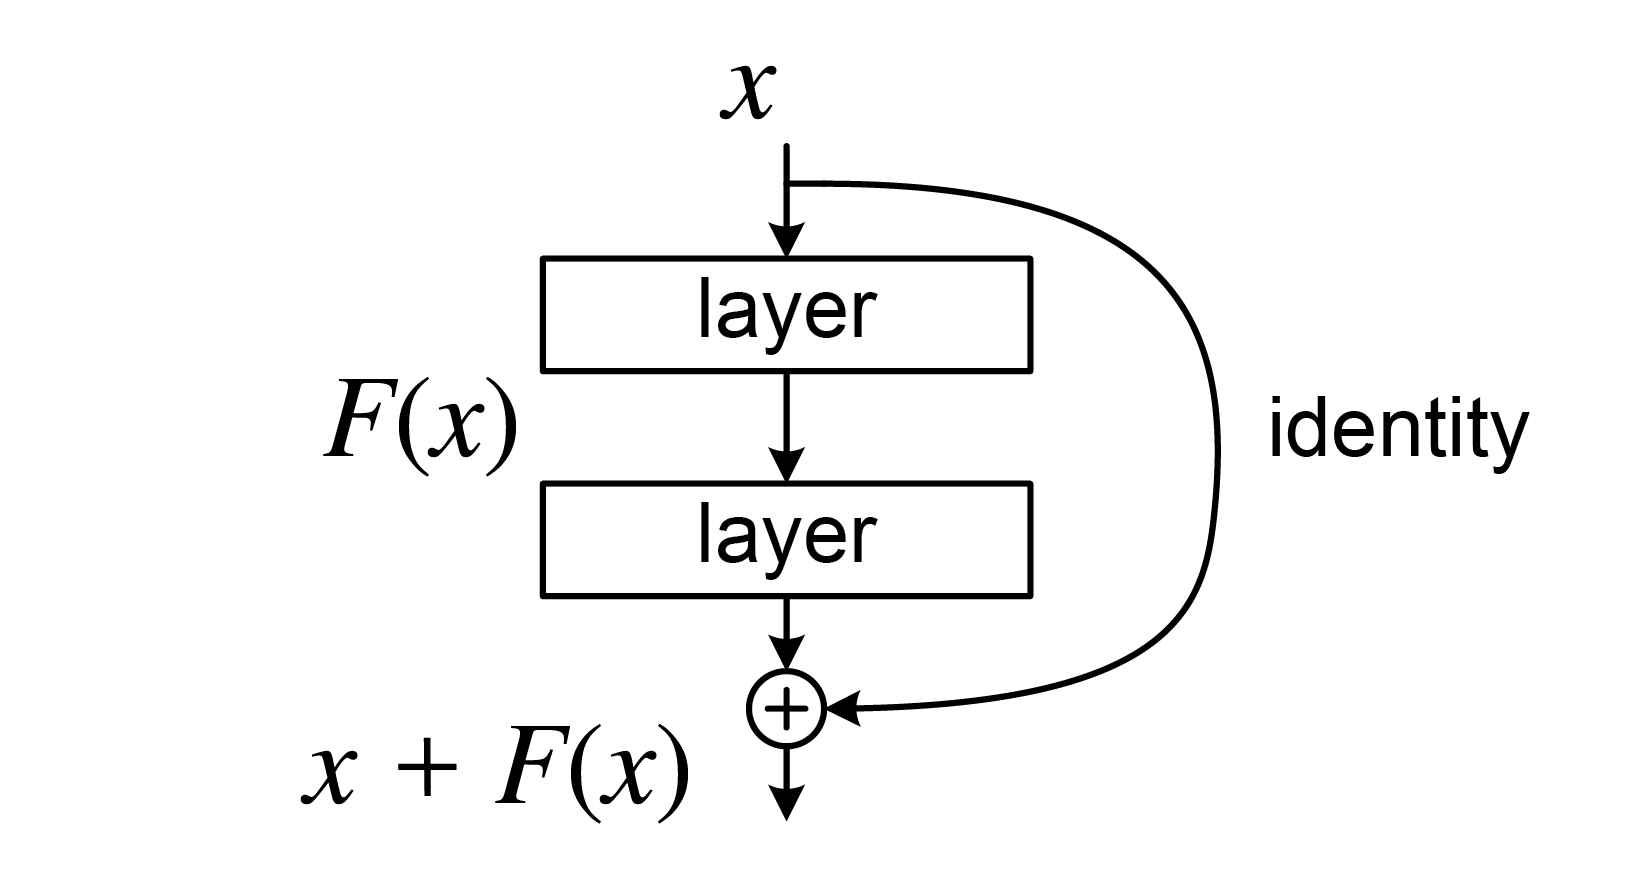

In [1]:
## Write a torch module for one skip layer as shown in the figure below

## A layer in the figure represent a sequential layer of conv layer -> batchnorm -> Activation function(ReLu)

## We expect by now, you have learnt about different arguments of torch.nn.Conv2D module like in_channels, out_channels, kernel_size, stride, and padding

##import modules whichever required
import torch

class SkipLayer(torch.nn.Module):
  def __init__(self,
               in_channels,
               out_channels) -> None:
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.block = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(num_features=out_channels),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(num_features=out_channels),
      torch.nn.ReLU()
    )
    if in_channels != out_channels:
      self.projection = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self,x):
    identity = x if self.in_channels == self.out_channels else self.projection(x)  # Create identity skip connection
    out = self.block(x)  # Pass the input through the sequential block
    out += identity
    return out  # Return the output after adding the identity skip connection


In [2]:
## Test your module

# 16-batchsize
# 4-channels
# 28 \times 28 - height \times width

random_sample = torch.randn((16,4,28,28))
skip_layer = SkipLayer(in_channels=4, out_channels=8)
print(skip_layer(random_sample).shape)

torch.Size([16, 8, 28, 28])


## Torchvision's Resnet [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
Now, that you have learnt what is skip connection module, now its time to use a Resnet module to our classification tasks on SAT-6 dataset.

Try to replace our predefined CNN with Resnet. Use already available Resnet module

Hints: The Resnet module from torchvision is developed for RGB images where input image has 3 channels. Please try to change it.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torchvision.models as models

### Create the Dataset

In [4]:
# obtain the data
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

--2025-06-01 12:12:42--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905628829 (864M) [text/plain]
Saving to: ‘X_test_sat6.csv.1’

X_test_sat6.csv.1   100%[===================>] 863,67M  25,4MB/s    in 34s     

2025-06-01 12:13:17 (25,4 MB/s) - ‘X_test_sat6.csv.1’ saved [905628829/905628829]

--2025-06-01 12:13:17--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 972000 (949K) [text/plain]
Saving to: ‘y_test_sat6.csv.1’

y_test_sat6.csv.1   100%[===================>] 949,22K  3,71MB/s    in 0,2s    

2025-06-01

In [5]:
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
annotations = pd.read_csv("./sat6annotations.csv", header=None)
labels_df = pd.read_csv("./y_test_sat6.csv",header=None)

# create random train/test split
train_idx = np.random.choice(landcover_df.index, size=int(0.8*len(landcover_df)), replace=False)
test_idx = landcover_df.index.difference(train_idx)
train_idx_downsampled = np.random.choice(train_idx, size=int(0.1*len(train_idx)), replace=False)
test_idx_downsampled = np.random.choice(test_idx, size=int(0.1*len(test_idx)), replace=False)

In [6]:
# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx_downsampled]
train_y = labels_df.iloc[train_idx_downsampled]
test_X = landcover_df.iloc[test_idx_downsampled]
test_y = labels_df.iloc[test_idx_downsampled]

train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

(array([111.813354, 114.25528 , 113.94445 , 106.59833 ], dtype=float32),
 array([54.325798, 47.43291 , 36.43221 , 76.749054], dtype=float32))

In [7]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [8]:
# define two dataset one for train and other for test
sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

In [9]:
print(f'number of train indices: {len(sat6_train_dataset)}, number of test indices: {len(sat6_test_dataset)}')

number of train indices: 6480, number of test indices: 1620


### Train Model

In [15]:
cnn = models.resnet18(weights=None)
# adapt the first and last layers to our dataset
cnn.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
cnn.fc = torch.nn.Linear(in_features=512, out_features=6, bias=True)
print(cnn)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
optim = "adam"
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001) if optim == "adam" else torch.optim.SGD(cnn.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
train_dataloader = DataLoader(sat6_train_dataset,batch_size=256,shuffle=True,drop_last=True)
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

In [19]:
num_epochs = 10
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []

with tqdm(total=num_epochs) as pbar:
  for i in range(num_epochs):
    cnn.train()
    for train_data_idx, train_data in enumerate(train_dataloader):
      optimizer.zero_grad()
      data, labels = train_data
      data = data.to(device)
      labels = labels.to(device)
      preds = cnn(data)
      train_loss = loss_fn(preds,labels)
      train_loss.backward()
      optimizer.step()
    # uncomment incase scheduler is defined above
    scheduler.step()
    training_loss_per_epoch.append(train_loss.item())

    cnn.eval()
    pred_labels = []
    true_labels = []
    with torch.no_grad():
      for test_data_idx, test_data in enumerate(test_dataloader):
        data, labels = test_data
        data = data.to(device)
        labels = labels.to(device)
        preds = cnn(data)
        val_loss = loss_fn(preds,labels)
        pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
        true_labels.extend(torch.squeeze(labels).to('cpu'))
    validation_loss_per_epoch.append(val_loss.item())
    acc = accuracy_score(true_labels,pred_labels)
    acc_per_epoch.append(acc)
    pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")

Epoch 10/10: training_loss : 0.02354598045349121, validation_loss : 0.12570321559906006 and accuracy : 0.9592592592592593 :   0%|          | 0/10 [10:32<?, ?it/s]


### Evaluation

In [20]:
# Get predictions and true labels from the test set
cnn.eval()
with torch.no_grad():
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        preds = cnn(data)
        pred_labels = torch.argmax(preds, dim=1).cpu().numpy()
        probs = torch.softmax(preds, dim=1).cpu().numpy()
        true_labels = labels.cpu().numpy()

# Compute confusion matrix
num_classes = preds.shape[1]
conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)
for t, p in zip(true_labels, pred_labels):
    conf_mat[t, p] += 1

# Calculate observed agreement (po)
po = np.trace(conf_mat) / np.sum(conf_mat)

# Calculate expected agreement (pe)
row_marginals = np.sum(conf_mat, axis=1)
col_marginals = np.sum(conf_mat, axis=0)
pe = np.sum(row_marginals * col_marginals) / (np.sum(conf_mat) ** 2)

# Calculate kappa
kappa = (po - pe) / (1 - pe)
print("Kappa score:", kappa)

Kappa score: 0.9447586601340114


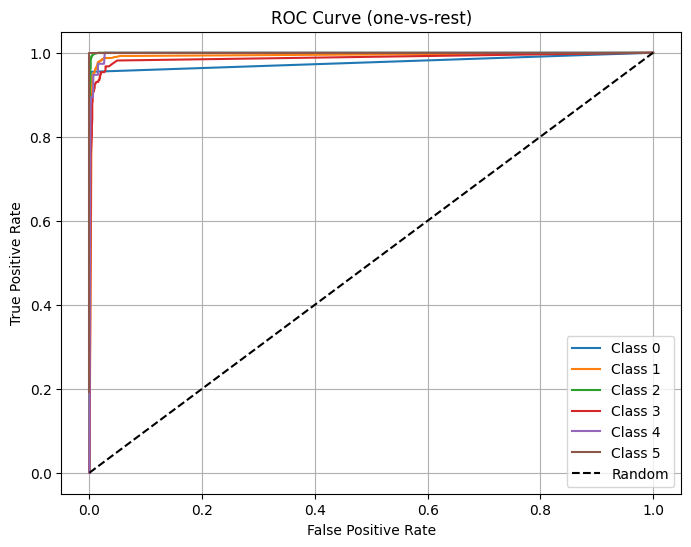

In [21]:
# Calculate and plot ROC curve for each class by varying threshold

# One-hot encode the true labels
num_classes = probs.shape[1]
true_onehot = np.zeros_like(probs)
true_onehot[np.arange(len(true_labels)), true_labels] = 1

# Compute ROC curve for each class
fpr = []
tpr = []
thresholds = np.linspace(0, 1, 101)
for class_idx in range(num_classes):
    class_fpr = []
    class_tpr = []
    for thresh in thresholds:
        pred = (probs[:, class_idx] >= thresh).astype(int)
        tp = np.sum((pred == 1) & (true_onehot[:, class_idx] == 1))
        fp = np.sum((pred == 1) & (true_onehot[:, class_idx] == 0))
        fn = np.sum((pred == 0) & (true_onehot[:, class_idx] == 1))
        tn = np.sum((pred == 0) & (true_onehot[:, class_idx] == 0))
        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
        class_tpr.append(tpr_val)
        class_fpr.append(fpr_val)
    tpr.append(class_tpr)
    fpr.append(class_fpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
for class_idx in range(num_classes):
    plt.plot(fpr[class_idx], tpr[class_idx], label=f'Class {class_idx}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (one-vs-rest)')
plt.legend()
plt.grid(True)
plt.show()

Done.